In [1]:
#use a hierchal bayesian model to put constraints on the age 
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
#get variable from the metallicity ages as new prior
from pymc3.distributions import Interpolated
import popsims
from astropy.coordinates import SkyCoord
import astropy.units as units
import corner
%matplotlib inline


Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:

import matplotlib as mpl
#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.top']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['ytick.left']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'

mpl.rcParams['font.serif'] = 'Ubuntu'
#mpl.rcParams['font.monospace'] = 'Ubuntu Mono'
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['figure.titlesize'] = 18

%matplotlib inline

In [3]:
UOBS=10.29496386,
VOBS=-0.15391868,
WOBS=-1.28539  
METAL=(0.25, 0.08) #measured metallicity
DATA_FOLDER='/users/caganze/research/J1624/data/'
FIG_FOLDER='/users/caganze/research/J1624/figures/'

In [4]:
#trappist one example
#UBOS=-43.74782869
#VOBS=-65.85697762
#WOBS=10.41498636
#METAL=(0.04, 0.08)

In [5]:
METAL[0]-METAL[-1]

0.16999999999999998

In [6]:
nsample=5e4
with pm.Model() as model:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    
    age=pm.Uniform('age', lower=1, upper=13.)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u, observed=UOBS)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v, observed=VOBS)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w, observed=WOBS)
                     
    trace = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )
    

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 58 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
#h=pm.traceplot(trace)

In [8]:
res=pm.summary(trace).round(2)

In [9]:
res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age,4.43,3.18,1.00,10.78,0.02,0.01,42315.0,41552.0,42659.0,48273.0,1.0
sigma_u,30.92,6.96,20.67,42.88,0.03,0.02,43013.0,42729.0,42659.0,48273.0,1.0
sigma_v,20.13,5.29,13.11,29.71,0.03,0.02,42807.0,42438.0,42659.0,48273.0,1.0
sigma_w,15.30,4.98,8.40,24.18,0.02,0.02,42895.0,42433.0,42659.0,48273.0,1.0


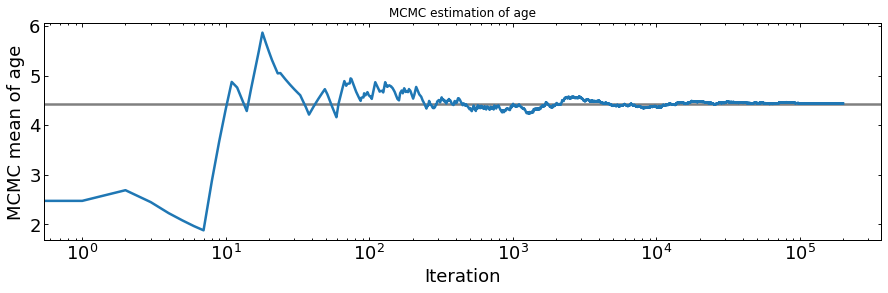

In [10]:
# plot the estimate for the mean of τ cumulating mean
tau = trace["age"]
mtau = [np.mean(tau[:i]) for i in np.arange(1, len(tau))]
plt.figure(figsize=(15, 4))
#plt.axhline(4.97, lw=2.5, color="gray")
plt.axhline(res['mean']['age'], lw=2.5, color="gray")
plt.plot(mtau, lw=2.5)
plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("MCMC mean of age")
plt.title("MCMC estimation of age");

In [11]:
trace.get_values('age')
sigma_v= (trace.sigma_u**2+ trace.sigma_v**2+ trace.sigma_w**2)**0.5

In [12]:
stat=trace.get_sampler_stats('accepted')
ages=trace.age[stat]
sigmas=sigma_v[stat]
samples= np.vstack([ages, trace.sigma_u[stat], trace.sigma_v[stat], trace.sigma_w[stat]])

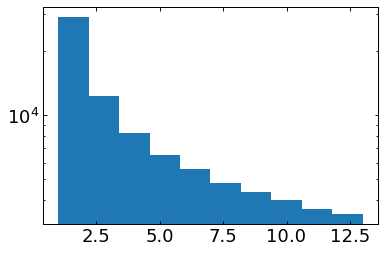

In [13]:
h=plt.hist(ages, log=True)

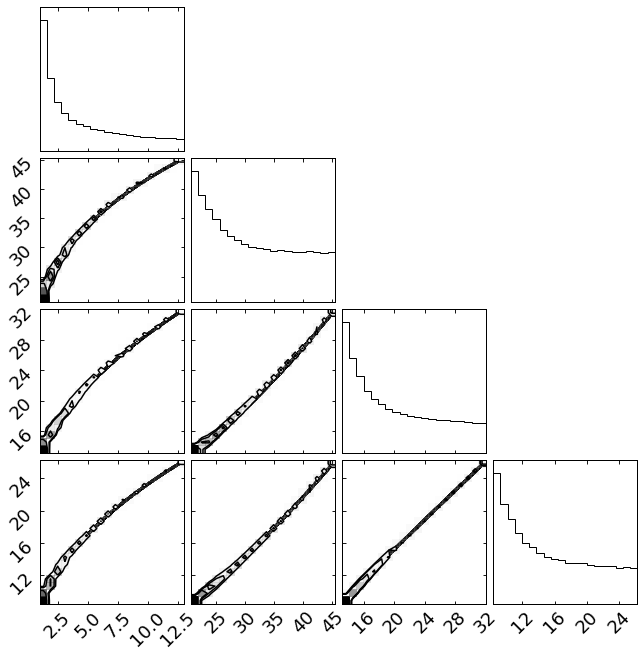

In [14]:
h=corner.corner(samples.T)

In [15]:
# pm.Deterministic?

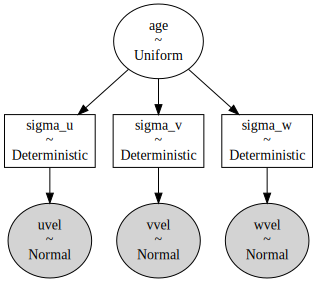

In [16]:
pm.model_to_graphviz(model)

In [17]:
def get_gaussian(mu, sigma):
    return np.random.normal(mu, sigma)

def distance_cdf(d):
    return d**3

In [18]:
#velocities
us=np.random.normal(UOBS, trace.sigma_u)
vs=np.random.normal(VOBS, trace.sigma_v)
ws=np.random.normal(WOBS, trace.sigma_w)

In [19]:
#positions
d_grid=np.linspace(0, 20, len(us))
cdfs=d_grid**3
ds=popsims.random_draw(d_grid, cdfs/np.nanmax(cdfs), len(us))

#spatial l and b
lg= np.random.uniform(0, 1, len(us))
bg=np.random.uniform(0, 1, len(us))
ras=2*np.pi*lg*units.radian.to(units.degree)
decs=(np.arccos(2*bg-1)-np.pi/2)*units.rad.to(units.degree)

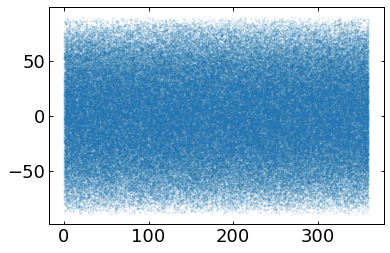

In [20]:
plt.scatter(ras, decs, s=1, alpha=0.1)

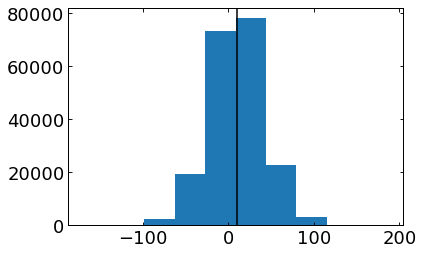

In [21]:
plt.hist(us)
plt.axvline(UOBS, c='k')

In [22]:
ds

array([16.24308122, 18.42639213, 19.34349672, ..., 16.80298401,
       11.15475577, 15.01357507])

In [23]:
from tqdm import tqdm

In [24]:
#proper motions
props =np.array([popsims.compute_pm_from_uvw(ras[idx], decs[idx], ds[idx],\
                                    us[idx], vs[idx], ws[idx], correct_lsr=False)\
                for idx in tqdm(np.arange(len(us)))])


100%|██████████| 200000/200000 [14:39<00:00, 227.45it/s]


In [25]:
np.shape(props)

(200000, 4)

In [26]:
ds

array([16.24308122, 18.42639213, 19.34349672, ..., 16.80298401,
       11.15475577, 15.01357507])

In [27]:
np.cos(np.pi)

-1.0

In [28]:
#create new coord object
new_coord= SkyCoord(ra=ras*units.degree, dec=decs*units.degree, distance=ds*units.pc,
                    radial_velocity=props[:,0]*units.km/units.s, 
                    pm_dec=props[:,2]*units.mas/units.yr, 
                    pm_ra_cosdec=props[:,1]*np.cos(decs*units.degree.to(units.radian))*units.mas/units.yr, 
                    frame='icrs')  


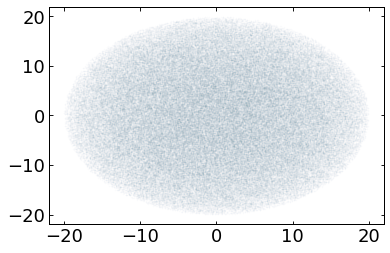

In [29]:
plt.scatter(new_coord.cartesian.x, new_coord.cartesian.z, s=1, alpha=0.01)

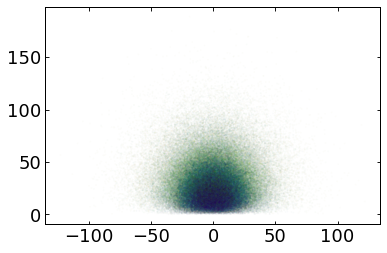

In [30]:
fig, ax = plt.subplots()
ax.scatter(vs, (us**2+ws**2)**0.5, s=1, c=np.log10(trace.age.flatten()),  alpha=0.01)
#ax.set(yscale='log')

In [31]:
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

In [32]:
np.log10(250)

2.3979400086720375

In [33]:
#m[1]
milky_way = gp.MilkyWayPotential()
H = gp.Hamiltonian(milky_way)
w0 = gd.PhaseSpacePosition(new_coord.cartesian)
orbits=H.integrate_orbit(w0,t=np.logspace(0, 2.4,100)*units.Myr, cython_if_possible=True)

In [34]:
#compute fraction of time spent within 20 pc
#orbits.

In [35]:
NPOINTS=len(us)

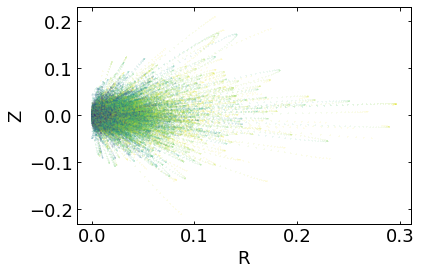

In [36]:
fig, ax=plt.subplots()
rs=(orbits.cartesian.x**2+orbits.cartesian.y**2)**0.5
for idx in np.random.choice(np.arange(0, NPOINTS-1), int(NPOINTS/100)):
    h=plt.scatter(rs[:,idx], orbits.cartesian.z[:,idx], 
               s=1, alpha=.1, marker='+', c=np.log10(orbits.t.value))
    plt.xlabel('R')
    plt.ylabel('Z')

In [37]:
orbits_ds=(orbits.cartesian.x**2+orbits.cartesian.y**2+orbits.cartesian.z**2)**0.5

In [38]:
within_20_pc_bool= orbits_ds.to(units.pc).value <=20.

In [39]:
weights=[orbits.t[within_20_pc_bool[:,idx]].max()/(100*units.Myr) for idx in range(len(us))]

In [40]:
weights=np.array(weights)

In [41]:
import scipy.stats as stats

In [42]:
age_weighted = np.histogram(trace.age, weights=weights)

In [43]:
rvs= stats.rv_histogram( np.histogram(trace.age, weights=weights))

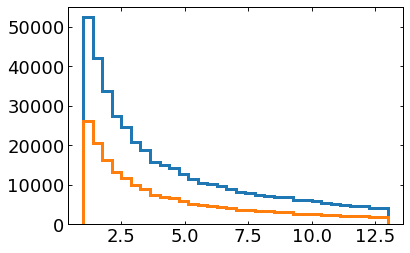

In [44]:
#visualization
fig, ax=plt.subplots()
_ = plt.hist(trace.age,  weights=weights, bins=32, histtype='step', lw=3, label='weighted') 
_ = plt.hist(trace.age,   bins=32, histtype='step', lw=3, label='unweighted') 

In [45]:
weighted_ages=rvs.rvs(size=len(trace.age))

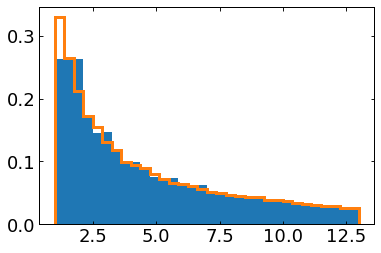

In [46]:
fig, ax=plt.subplots()
h=plt.hist(weighted_ages, bins=32, density=True)
_ = plt.hist(trace.age,  weights=weights, bins=32, histtype='step', lw=3, label='weighted', density=True) 

[None, Text(0.5, 0, 'Age (Gyr)'), Text(0.5, 1.0, 'Metallicity')]

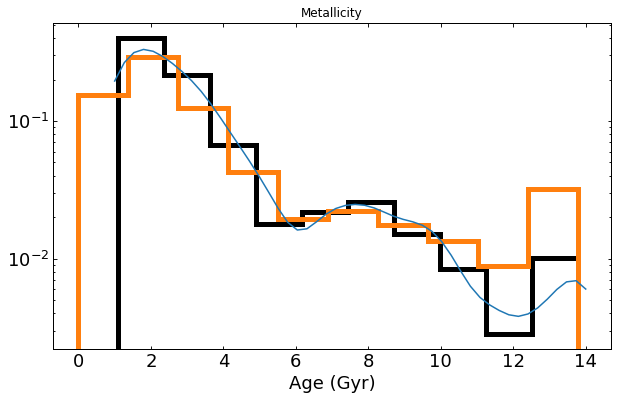

In [69]:
#model with metallicity prior
import pandas as pd
gcs=pd.read_csv('/users/caganze/research/J1624/data//gcs_catalog.csv')


#take everything within 3 sigma
bools=np.logical_and(gcs['__Fe_H_'].between(METAL[0]-1*METAL[-1], METAL[0]+1*METAL[-1]).values, 
                            ~np.isnan(gcs.ageMLP.values))
age_bools=(gcs.ageMLP.values>1.)
gcs_ages=gcs.ageMLP[bools & age_bools].values

#INTERPOLATED FROM SIMULATIONS

SIM_X=np.linspace(1, 14)
SIM_Y= stats.gaussian_kde(gcs_ages)(SIM_X)

fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(SIM_X, SIM_Y)
#ax.hist(gcs_ages, density=True)
ax.hist(gcs.ageMLP.values[bools & age_bools], density=True, histtype='step', lw=5, color='k')
ax.hist(gcs.ageMLP.values, density=True, histtype='step', lw=5)

ax.set(yscale='log', xlabel='Age (Gyr)', title='Metallicity')

In [50]:
#asymetric_errors(gcs.ageMLP.values[bools])

In [70]:

#add my own likelihood (chisquare)
def logp(u, v, w):
    return -(u-UOBS)**2-(v-VOBS)**2-(w-WOBS)**2
with pm.Model() as model_custom:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    
    
    #beta=pm.Uniform('beta', lower=0.001, upper=1.)
    #age=pm.Gamma('age', alpha=5., beta=beta)
    #age=pm.Uniform('age', lower=0.0, upper=13.)
    age=Interpolated('age', SIM_X, SIM_Y)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w)
    
    like = pm.Potential('likelihood', logp(uvel, vvel, wvel))
    
    trace_metal = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [wvel]
>Metropolis: [vvel]
>Metropolis: [uvel]
>Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 173 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [52]:
from astropy.io import ascii

[Text(0.5, 1.0, 'CDF')]

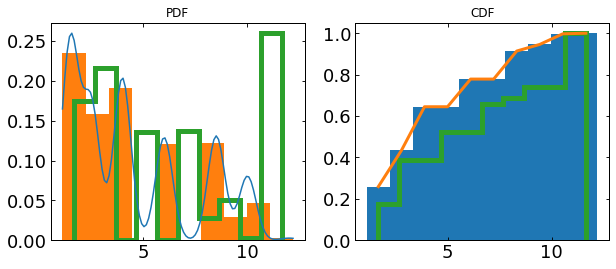

In [63]:
besca=ascii.read('/users/caganze/Downloads/output').to_pandas()

#make a cut on age
besca=besca[besca.Age.values>1.]
#
#width = smax - smin
BESA_X = np.linspace(besca.Age.values.min(),  besca.Age.values.max(), 100)
BESA_Y = stats.gaussian_kde(besca.Age.values)(BESA_X)

fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4))
ax.plot(BESA_X, BESA_Y, label='KDE original')
h=ax.hist(besca.Age.values, density=True,label='Original')

h1=ax1.hist(besca.Age.values, density=True, cumulative=True, label='Original')

bin_edges=h1[1]
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2

ax1.plot(bin_centers, h1[0], lw=3)

#redraw 
redrawn= popsims.random_draw(bin_centers, h1[0], int(1e4))

h2=ax.hist(redrawn, density=True,label='Redrawn',  histtype='step', lw=5)
h3=ax1.hist(redrawn, density=True,label='Redrawn', histtype='step', cumulative=True, lw=5)

ax.set(title='PDF')
ax1.set(title='CDF')


In [64]:
with pm.Model() as model_besa:
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445
    k = 74.
    
    
    #beta=pm.Uniform('beta', lower=0.001, upper=1.)
    #age=pm.Gamma('age', alpha=5., beta=beta)
    #age=pm.Uniform('age', lower=0.0, upper=13.)
    age=Interpolated('age', BESA_X, BESA_Y)
    
    sigma_u = pm.Deterministic('sigma_u',  v10*((age+tau1)/(10.+tau1))**beta)
    uvel =pm.Normal('uvel', mu=0.0, sigma=sigma_u)

    sigma_v = pm.Deterministic('sigma_v', v10_v*((age+tau_v)/(10.+tau_v))**beta_v)
    
    voff = -1.*(sigma_v**2)/k
    vvel = pm.Normal('vvel', mu=voff,sigma=sigma_v)
    
    sigma_w = pm.Deterministic('sigma_w', v10_w*((age+tau_w)/(10.+tau_w))**beta_w)
    wvel = pm.Normal('wvel', mu=0., sigma=sigma_w)
    
    like = pm.Potential('likelihood', logp(uvel, vvel, wvel))
    
    trace_besa = pm.sample(draws=int(nsample), cores=4, tune=int(nsample/20),
            discard_tuned_samples=True, step=pm.Metropolis(), return_inferencedata=False )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [wvel]
>Metropolis: [vvel]
>Metropolis: [uvel]
>Metropolis: [age]


Sampling 4 chains for 2_500 tune and 50_000 draw iterations (10_000 + 200_000 draws total) took 157 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [71]:
all_ds=[trace.age, weighted_ages,   trace_metal.age, trace_besa.age]

In [66]:
def asymetric_errors(vals):
    if len(vals)<1:
        return [np.nan, np.nan]
    else:
        med= np.nanmedian(vals)
        up= np.nanpercentile(vals, 86)
        dn= np.nanpercentile(vals, 14)
        return med, np.array([med-dn, up-med])

In [57]:
#meds[1].reshape(1, 2).T

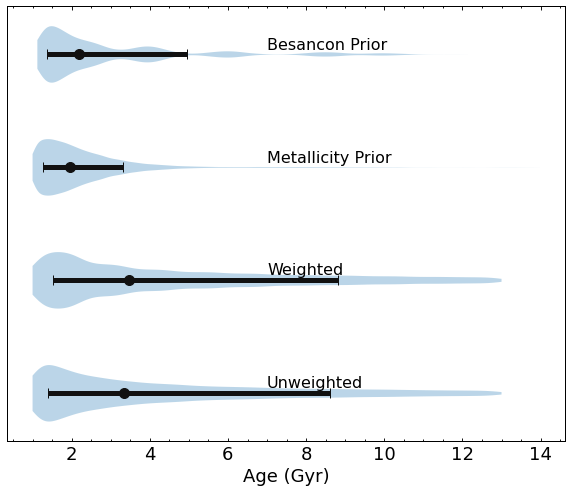

In [72]:
fig, ax=plt.subplots(figsize=(10, 8))
ax.violinplot(all_ds,points=1000, positions=[0, 1, 2, 3], 
               showmeans=False, showmedians=False, showextrema=False, vert =False)
ax.set(xlabel='Age (Gyr)')
ax.minorticks_on()
ax.get_yaxis().set_ticks([])
yticklabels=['Unweighted', 'Weighted', 'Metallicity Prior', 'Besancon Prior']
for pos, tx in zip([0, 1, 2, 3], yticklabels):
    ax.text(7, pos+0.05, tx, fontsize=16)
    meds=asymetric_errors(all_ds[pos])
    ax.errorbar(meds[0], pos, xerr=meds[1].reshape(1, 2).T,  fmt='o', 
               ms=10, lw=5,  mfc='#111111', mec='#111111', ecolor='#111111', capsize=5)
    
plt.savefig(FIG_FOLDER+'/age_constraints_activity_prior.pdf', bbox_inches='tight')

In [68]:
for d in all_ds:
    print (asymetric_errors(d))

(3.3373729137770485, array([1.93252363, 5.2792018 ]))
(3.4710774407952414, array([1.93806839, 5.35282925]))
(1.624465665709007, array([0.96342522, 1.37728782]))
(2.1848125074658435, array([0.80489373, 2.76236655]))


In [60]:
asymetric_errors(weighted_ages)

(3.4710774407952414, array([1.93806839, 5.35282925]))

In [61]:
HJKKL

NameError: name 'HJKKL' is not defined